### make some simple models to see how the dust radius and mass change with time

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.optimize import fsolve
%matplotlib inline

In [2]:
import astropy.constants as c
import astropy.units as u
au = c.au.cgs.value
mH = c.m_p.cgs.value
kB = c.k_B.cgs.value
msun = c.M_sun.cgs.value
G = c.G.cgs.value
mearth = c.M_earth.cgs.value

In [3]:
# Lynden-Bell & Pringle surface density profile for gamma=1
def sigma1(r, sigma0, rc):
    return sigma0 / (r/rc) / np.exp(r/rc)

def logsigma1(r, sigma0, rc):
    return np.log10(sigma0 / (r/rc) / np.exp(r/rc))

In [4]:
# Powell prescription for the surface density at 1 Myr; all variables in cgs
def powell(v0, rho_s, s, r):
    Myr2seconds = 3.15e13
    Sigma_dust = 2.5 * Myr2seconds * v0 * rho_s * s / r
    return Sigma_dust

In [5]:
# Trapman prescription for the surface density in g/cm2 at the 90% CO radius for a disk with gas+dust mass M
def trapman(M, L):
    logL = np.log10(L)
    #Sigma_CO = 0.0143 * M**0.34
    Sigma_CO = 10**(-2.15-0.53*logL) * M**(0.30-0.08*logL)
    return Sigma_CO

In [6]:
def fitsigma1(R, Sigma):
    # solve equation for gamma=1
    Rc = (R[0]-R[1]) / np.log(Sigma[1]*R[1] / (Sigma[0]*R[0]))
    Sigma0 = Sigma[0] * (R[0] / Rc) * np.exp(R[0]/Rc)
    return Sigma0, Rc

In [7]:
def match_mass(t, R, Sigma, Mdust):
    Sigma_drift = Sigma.copy()
    Sigma_drift[0] *= t
    Sigma0, Rc = fitsigma1(R, Sigma_drift)

    x = np.logspace(0, 3, num=30)
    M = 3.747e-4 * np.trapz(2*np.pi*x*sigma1(x, Sigma0, Rc), x)    # earth masses of dust (for g/d=100)

    return M-Mdust

In [8]:
def toomre(t, R, Sigma, Mstar, Lstar):
    Sigma_drift = Sigma.copy()
    Sigma_drift[0] *= t
    Sigma0, Rc = fitsigma1(R, Sigma_drift)

    x = np.logspace(0, 3, num=30)
    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7) 
    T = T0 * x**(-3/7)
    c_s = 5952 * np.sqrt(T)
    Omega = 1.99e-7 * np.sqrt(Mstar / x**3)
    Q = 4.77e6 * c_s * Omega / sigma1(x, Sigma0, Rc)
    Qmin = np.min(Q)

    return Qmin-1

In [9]:
def mq(R, Sigma0, Rc, Mstar, Lstar):
    # calculate the total mass and Toomre Q profile over R in au
    Sigma_fit = sigma1(R, Sigma0, Rc)

    # integrate Sigma to get total mass
    M = 1.125e-7 * np.trapz(Sigma_fit*2*np.pi*R, R)    # solar masses

    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7) 
    T = T0 * R**(-3/7)
    c_s = 5952 * np.sqrt(T)
    Omega = 1.99e-7 * np.sqrt(Mstar / R**3)
    Q = 4.77e6 * c_s * Omega / Sigma_fit

    return M, Q

In [10]:
def get_Sigma(Mstar=1, Lstar=1, Mdisk=0.01, Rmm=100):
    T0 = 82 * (Lstar/0.28)**(2/7) / (Mstar/0.8)**(1/7)  # midplane temperature at 1au Powell 2017 equation 2
    rho_s = 2.0                                         # g/cm^3
    s = 0.1 / (2*np.pi)                                 # grain size in cm

    # drift speed in cm/s
    T = T0 * (Rmm)**(-3/7)
    c_s = np.sqrt(kB * T / (2.33 * mH))
    v_k = np.sqrt(G * Mstar * msun / (Rmm * au))
    v0 = c_s**2 / (2 * v_k)
    #print(f'Drift speed = {v0/1e5:5.3f} km/s')

    # surface density for dust at 1 Myr and CO at given Mdisk
    Sigma = np.array([powell(v0, rho_s, s, Rmm*au), trapman(Mdisk, Lstar)])

    return(Sigma)

In [11]:
def fit_data(Mstar=1, Lstar=1, Rmm=100, RCO=300, plot_to_screen=False):
    R_obs = [Rmm, RCO]
    Sigma = get_Sigma()
    #Mdust = 0.01 * Mdisk * msun / mearth

    if plot_to_screen:
        plt.ion()
    else:
        plt.ioff()

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    fontsize = 16

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(2, 1e3)
    ax.set_ylim(7e-4, 1e3)
    ax.grid(which='both', alpha=0.3, ls='--') 

    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.set_ylim(0.1, 100)
    ax2.plot([0, 1e3], [1, 1], ':', lw=3, alpha=0.5, color='black')

    ax.set_xlabel('r (au)', fontsize=fontsize)
    ax.set_ylabel(r'$\Sigma_{\rm gas}$ (g cm$^{-2}$)', fontsize=fontsize)
    ax2.set_ylabel('Toomre Q', fontsize=fontsize)

    R_plot = np.logspace(0, 3, num=30)
    M_fit = []
    max_iter = 10

    # initial guesses for drift time and max stable disk mass
    t0 = 0.1
    mdisk0 = 0.1

    # solve just for the marginally stable case
    for i in range(1,2):
        if i == 0:
            # disk mass = 100 * dust mass
            color = 'blue'
            #label = str(f"100M_dust = {100*Mdust*mearth/msun:6.3f}")
            label = str(f"M = {100*Mdust*mearth/msun:6.3f}")
            #label = r"$M=100M_{\rm dust}$"
            t_drift = fsolve(match_mass, t0, args=(R_obs, Sigma, Mdust))[0]
            td0 = t_drift
        if i == 1:
            # disk is marginally gravitationally stable
            color = 'red'
            iter = 0
            mdisk_converge = False
            while iter < max_iter and not mdisk_converge:
                Sigma_iter = Sigma.copy()
                Sigma_iter[1] = trapman(mdisk0, Lstar)
                t_drift = fsolve(toomre, t0, args=(R_obs, Sigma_iter, Mstar, Lstar))[0]
                Sigma_iter[0] *= t_drift
                Sigma0, Rc = fitsigma1(R_obs, Sigma_iter)
                Sigma_fit = sigma1(R_plot, Sigma0, Rc)
                mdisk1 = 1.125e-7 * np.trapz(Sigma_fit*2*np.pi*R_plot, R_plot)
                print(f'Trapman iteration {iter}: t_drift={t_drift:6.3f}   Mass change {mdisk0:6.3f} --> {mdisk1:6.3f}')
                if np.abs(mdisk1/mdisk0-1) <  0.99:
                    mdisk_converge = True
                mdisk0 = mdisk1
                iter += 1
            #label = str(f"M(Q=1) = {mdisk0:6.3f}")
            label = str(f"M = {mdisk0:6.3f}")
            #label = r"$Q=1$"
        Sigma_drift = Sigma.copy()
        Sigma_drift[0] *= t_drift
        td1 = t_drift
        if i==1:
            Sigma_drift[1] = trapman(mdisk0, Lstar)

        ax.plot(R_obs, Sigma_drift, 'o', color=color, label=label)
        Sigma0, Rc = fitsigma1(R_obs, Sigma_drift)
        M, Q = mq(R_plot, Sigma0, Rc, Mstar, Lstar)
        M_fit.append(M)

        Sigma_plot = sigma1(R_plot, Sigma0, Rc)
        tau1 = Sigma_plot > 50
        ax.plot(R_plot, Sigma_plot, '-', color=color)
        ax.plot(R_plot[tau1], Sigma_plot[tau1], '-', color=color, lw=3)
        ax2.plot(R_plot, Q, '--', color=color, zorder=0)
        #ax.legend(fontsize=fontsize-6)

        print(f'tdrift ={t_drift:6.3f} Myr, M = {M:6.4f} solar masses, Qmin = {np.min(Q):5.2f}')

    #ax.text(0.03, 0.04, f'Drift times = {td0:3.1f}-{td1:3.1f} Myr', fontsize=fontsize-4, ha='left', transform=ax.transAxes, zorder=3)
    ax.text(0.03, 0.04, f'Drift time = {td1:4.2f} Myr', fontsize=fontsize-4, ha='left', transform=ax.transAxes, zorder=3)
    fig.tight_layout()
    fig.savefig('test.png')

    if not plot_to_screen:
        plt.close()

    #return td0, td1, *M_fit
    return td1, *M_fit

Trapman iteration 0: t_drift= 0.111   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift= 0.137   Mass change  0.354 -->  0.358
tdrift = 0.137 Myr, M = 0.3566 solar masses, Qmin =  1.01


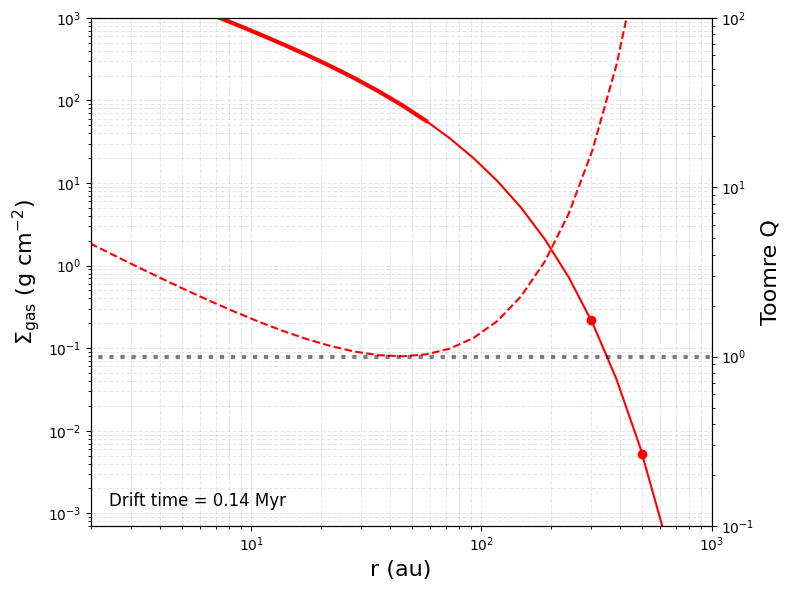

In [12]:
td, M = fit_data(Rmm=300, RCO=500, plot_to_screen=True)

In [13]:
RCO = 100
Rmm_100 = [30, 40, 50, 60]
tdrift_100 = []
Mdisk_100 = []
for R1 in Rmm_100:
    td1, M1 = fit_data(Rmm=R1, RCO=RCO, plot_to_screen=False)
    tdrift_100.append(td1)
    Mdisk_100.append(M1)

Trapman iteration 0: t_drift=22.679   Mass change  0.100 -->  0.186
tdrift =22.679 Myr, M = 0.1763 solar masses, Qmin =  1.06
Trapman iteration 0: t_drift= 5.411   Mass change  0.100 -->  0.186
tdrift = 5.411 Myr, M = 0.1694 solar masses, Qmin =  1.11
Trapman iteration 0: t_drift= 1.377   Mass change  0.100 -->  0.186
tdrift = 1.377 Myr, M = 0.1602 solar masses, Qmin =  1.17
Trapman iteration 0: t_drift= 0.365   Mass change  0.100 -->  0.186
tdrift = 0.365 Myr, M = 0.1473 solar masses, Qmin =  1.28


In [14]:
RCO = 200
Rmm_200 = [45, 60, 80, 100, 120]
tdrift_200 = []
Mdisk_200 = []
for R1 in Rmm_200:
    td1, M1 = fit_data(Rmm=R1, RCO=RCO, plot_to_screen=False)
    tdrift_200.append(td1)
    Mdisk_200.append(M1)

Trapman iteration 0: t_drift=26.589   Mass change  0.100 -->  0.249
Trapman iteration 1: t_drift=27.840   Mass change  0.249 -->  0.252
tdrift =27.840 Myr, M = 0.2518 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 9.294   Mass change  0.100 -->  0.249
Trapman iteration 1: t_drift= 9.948   Mass change  0.249 -->  0.252
tdrift = 9.948 Myr, M = 0.2517 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 2.519   Mass change  0.100 -->  0.249
Trapman iteration 1: t_drift= 2.777   Mass change  0.249 -->  0.252
tdrift = 2.777 Myr, M = 0.2516 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 0.728   Mass change  0.100 -->  0.249
Trapman iteration 1: t_drift= 0.827   Mass change  0.249 -->  0.252
tdrift = 0.827 Myr, M = 0.2513 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 0.219   Mass change  0.100 -->  0.249
Trapman iteration 1: t_drift= 0.256   Mass change  0.249 -->  0.252
tdrift = 0.256 Myr, M = 0.2510 solar masses, Qmin =  1.00


In [15]:
RCO = 500
Rmm_500 = [70, 100, 150, 200, 250, 300]
tdrift_500 = []
Mdisk_500 = []
for R1 in Rmm_500:
    td1, M1 = fit_data(Rmm=R1, RCO=RCO, plot_to_screen=False)
    tdrift_500.append(td1)
    Mdisk_500.append(M1)
    #input("Press Enter to continue")

Trapman iteration 0: t_drift=23.536   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift=24.027   Mass change  0.354 -->  0.358
tdrift =24.027 Myr, M = 0.3583 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 9.905   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift=10.368   Mass change  0.354 -->  0.358
tdrift =10.368 Myr, M = 0.3582 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 2.828   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift= 3.086   Mass change  0.354 -->  0.358
tdrift = 3.086 Myr, M = 0.3580 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 0.908   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift= 1.033   Mass change  0.354 -->  0.358
tdrift = 1.033 Myr, M = 0.3577 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 0.311   Mass change  0.100 -->  0.354
Trapman iteration 1: t_drift= 0.369   Mass change  0.354 -->  0.358
tdrift = 0.369 Myr, M = 0.3572 solar masses, Qmin =  1.00
Trapman iteration 0: t_drift= 

In [16]:
RCO = 50
Rmm_50 = [20, 25, 30]
tdrift_50 = []
Mdisk_50 = []
for R1 in Rmm_50:
    td1, M1 = fit_data(Rmm=R1, RCO=RCO, plot_to_screen=False)
    tdrift_50.append(td1)
    Mdisk_50.append(M1)
    #input("Press Enter to continue")

Trapman iteration 0: t_drift=11.545   Mass change  0.100 -->  0.129
tdrift =11.545 Myr, M = 0.1241 solar masses, Qmin =  1.05
Trapman iteration 0: t_drift= 2.589   Mass change  0.100 -->  0.129
tdrift = 2.589 Myr, M = 0.1213 solar masses, Qmin =  1.07
Trapman iteration 0: t_drift= 0.605   Mass change  0.100 -->  0.129
tdrift = 0.605 Myr, M = 0.1172 solar masses, Qmin =  1.11


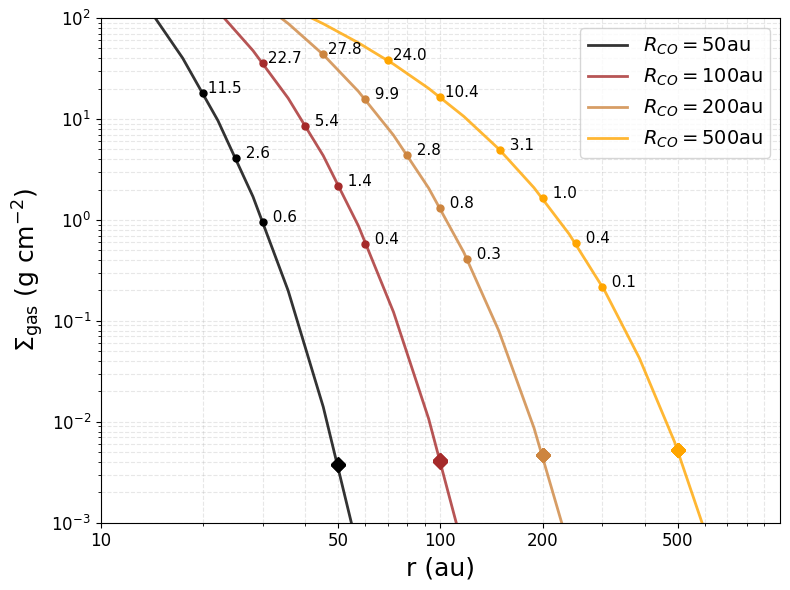

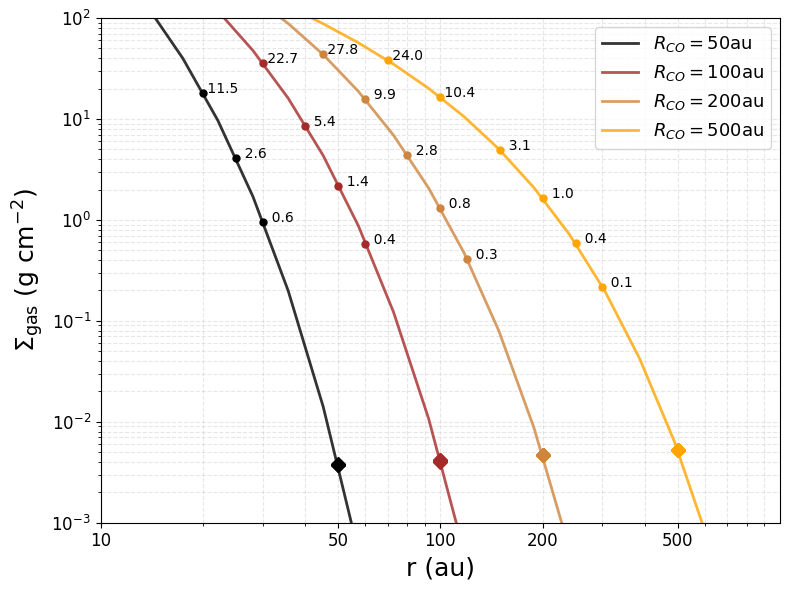

In [19]:
Mstar = 1
Lstar =1

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.ion()
fontsize = 18
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 1e3)
ax.set_xticks([10, 50, 100, 200, 500])
ax.set_xticklabels(['10', '50', '100', '200', '500'])
ax.set_ylim(1e-3, 100)
ax.grid(which='both', alpha=0.3, ls='--') 
ax.set_xlabel('r (au)', fontsize=fontsize)
ax.set_ylabel(r'$\Sigma_{\rm gas}$ (g cm$^{-2}$)', fontsize=fontsize)
#ax.tick_params(axis='both', which='major', labelsize=12)

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2.set_ylim(0.1, 100)
#ax2.plot([0, 1e3], [1, 1], ':', lw=3, alpha=0.5, color='black')
#ax2.set_ylabel('Toomre Q', fontsize=fontsize)

R_plot = np.logspace(0, 3, num=30)

color = 'black'
RCO = 50
for i, n in enumerate(range(len(Rmm_50))):
    R_obs = [Rmm_50[n], RCO]
    td = tdrift_50[n]
    Sigma = get_Sigma()
    Sigma[0] *= td
    ax.plot(R_obs[0], Sigma[0], 'o', ms=5, color=color)
    ax.text(R_obs[0], Sigma[0], str(f"{td:5.1f}"), fontsize=10)
    Sigma[1] = trapman(Mdisk_50[n], Lstar)
    ax.plot(RCO, Sigma[1], 'D', ms=7, color=color)
    if i==0:
        Sigma_plot = sigma1(R_plot, *fitsigma1(R_obs, Sigma))
        ax.plot(R_plot, Sigma_plot, '-', color=color, alpha=0.8, lw=2, label=r'$R_{CO}=50$au')

color = 'brown'
RCO = 100
for i, n in enumerate(range(len(Rmm_100))):
    R_obs = [Rmm_100[n], RCO]
    td = tdrift_100[n]
    Sigma = get_Sigma()
    Sigma[0] *= td
    ax.plot(R_obs[0], Sigma[0], 'o', ms=5, color=color)#, label=label)
    ax.text(R_obs[0], Sigma[0], str(f"{td:5.1f}"), fontsize=10)
    Sigma[1] = trapman(Mdisk_100[n], Lstar)
    ax.plot(RCO, Sigma[1], 'D', ms=7, color=color)#, label=label)
    if i==0:
        Sigma_plot = sigma1(R_plot, *fitsigma1(R_obs, Sigma))
        ax.plot(R_plot, Sigma_plot, '-', color=color, alpha=0.8, lw=2, label=r'$R_{CO}=100$au')

color = 'peru'
RCO = 200
for i, n in enumerate(range(len(Rmm_200))):
    R_obs = [Rmm_200[n], RCO]
    td = tdrift_200[n]
    Sigma = get_Sigma()
    Sigma[0] *= td
    ax.plot(R_obs[0], Sigma[0], 'o', ms=5, color=color)#, label=label)
    ax.text(R_obs[0], Sigma[0], str(f"{td:5.1f}"), fontsize=10)
    Sigma[1] = trapman(Mdisk_200[n], Lstar)
    ax.plot(RCO, Sigma[1], 'D', ms=7, color=color)#, label=label)
    if i==0:
        Sigma_plot = sigma1(R_plot, *fitsigma1(R_obs, Sigma))
        ax.plot(R_plot, Sigma_plot, '-', color=color, alpha=0.8, lw=2, label=r'$R_{CO}=200$au')

color = 'orange'
RCO = 500
for i, n in enumerate(range(len(Rmm_500))):
    R_obs = [Rmm_500[n], RCO]
    td = tdrift_500[n]
    Sigma = get_Sigma()
    Sigma[0] *= td
    ax.plot(R_obs[0], Sigma[0], 'o', ms=5, color=color)#, label=label)
    ax.text(R_obs[0], Sigma[0], str(f"{td:5.1f}"), fontsize=10)
    Sigma[1] = trapman(Mdisk_500[n], Lstar)
    ax.plot(RCO, Sigma[1], 'D', ms=7, color=color)#, label=label)
    if i==0:
        Sigma_plot = sigma1(R_plot, *fitsigma1(R_obs, Sigma))
        ax.plot(R_plot, Sigma_plot, '-', color=color, alpha=0.8, lw=2, label=r'$R_{CO}=500$au')

    #M, Q = mq(R_plot, Sigma0, Rc, Mstar, Lstar)
    #ax2.plot(R_plot, Q, '--', color=color, zorder=0)
    #tau1 = Sigma_plot > 50
    #ax.plot(R_plot[tau1], Sigma_plot[tau1], '-', color=color, lw=3)

    #print(f'tdrift ={tdrift:6.3f} Myr, M = {M:6.4f} solar masses, Qmin = {np.min(Q):5.2f}')
    #ax.text(0.03, 0.04, f'Drift time = {tdrift:4.2f} Myr', fontsize=fontsize-4, ha='left', transform=ax.transAxes, zorder=3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=13)
fig.tight_layout()
fig.savefig('drift_models.pdf')

In [18]:
#plot_fit(Rmm=250, RCO=500, Mdisk=M, tdrift=td)